In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
import torchvision
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np

In [2]:
voc_dir = Path(r'../data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012')

In [3]:
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_dir = voc_dir / 'ImageSets' / 'Segmentation'
    txt_fpath = txt_dir / 'train.txt' if is_train else txt_dir / 'val.txt'
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fpath.as_posix(), 'r') as f:
        image_name_list = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(image_name_list):
        features.append(torchvision.io.read_image((voc_dir / 'JPEGImages' / f'{fname}.jpg').as_posix()))
        labels.append(torchvision.io.read_image((voc_dir / 'SegmentationClass' / f'{fname}.png').as_posix(), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

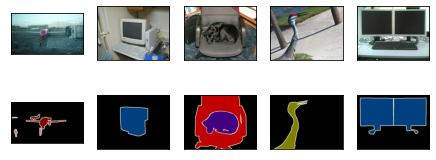

In [4]:
# 绘制前5个输入图像及其标签
n = 5
imgs = train_features[0: n] + train_labels[0: n]
imgs = [img.permute(1, 2, 0) for img in imgs]
utils.show_images(imgs, 2, n);

In [5]:
# 常量，RGB颜色值和类名
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
def voc_colormap2label():
    """
        构建从RGB到VOC类别索引的映射
        即：可以给定一个rgb颜色索引即可对应出类别
    """
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)    # rgb三通道空间大小为256 * 256 *256，将rgb以256进制计算为一个数字
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

In [7]:
def voc_label_indices(colormap, colormap2label):
    """
        将VOC标签中的RGB值映射到它们的类别索引
    """
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = (colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]    # 通过不同权重叠加整合，三通道合并为一通道
    return colormap2label[idx]

In [8]:
colormap2label = voc_colormap2label()
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

# 预处理数据

In [9]:
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

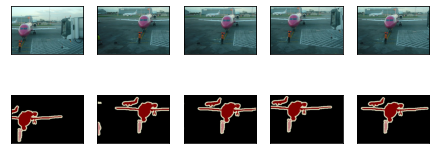

In [10]:
imgs = []
for _ in range(n):
    imgs.extend(voc_rand_crop(train_features[0], train_labels[0], 200, 300))

imgs = [img.permute(1, 2, 0) for img in imgs]
utils.show_images(imgs[::2] + imgs[1::2], 2, n);

# 自定义语义分割数据集类

In [21]:
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        self.colormap2label = voc_colormap2label()
        txt_dir = voc_dir / 'ImageSets' / 'Segmentation'
        txt_fpath = txt_dir / 'train.txt' if is_train else txt_dir / 'val.txt'
        self.mode = torchvision.io.image.ImageReadMode.RGB
        with open(txt_fpath.as_posix(), 'r') as f:
            image_name_list = f.read().split()
        self._img_path_list = [voc_dir / 'JPEGImages' / f'{fname}.jpg' for fname in image_name_list]
        self._label_path_list = [voc_dir / 'SegmentationClass' / f'{fname}.png' for fname in image_name_list]
        
        self.img_path_list = list()
        self.label_path_list = list()
        for img_path in self._img_path_list:
            img = torchvision.io.read_image(img_path.as_posix())
            if self.crop_check(img):
                self.img_path_list.append(img_path)
        for label_path in self._label_path_list:
            label = torchvision.io.read_image(label_path.as_posix(), self.mode)
            if self.crop_check(label):
                self.label_path_list.append(label_path) 
                
        self._img_path_list = self._label_path_list = None
        print('read ' + str(len(self.img_path_list)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def crop_check(self, img):
        return img.shape[1] >= self.crop_size[0] and img.shape[2] >= self.crop_size[1]
    
    def filter(self, imgs):
        return [img for img in imgs if (img.shape[1] >= self.crop_size[0] and img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        _img = self.normalize_image(torchvision.io.read_image(self.img_path_list[idx].as_posix()))
        _label = torchvision.io.read_image(self.label_path_list[idx].as_posix(), self.mode)
        img, label = voc_rand_crop(_img, _label, *self.crop_size)
        return (img, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.img_path_list)

In [22]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [23]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, drop_last=True, num_workers=utils.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


# 整合所有组件

In [25]:
def load_data_voc(batch_size, crop_size, voc_dir):
    """加载VOC语义分割数据集"""
    num_workers = utils.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size, voc_dir), batch_size, drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [26]:
train_iter, test_iter = load_data_voc(batch_size=64, crop_size=(320, 480), voc_dir=voc_dir)
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break
for X, Y in test_iter:
    print(X.shape)
    print(Y.shape)
    break

read 1114 examples
read 1078 examples
torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])
torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])
